## Я залил этот коммит немного позже 23:59, если это действительно важно, то есть коммит до 23:59

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
train = reduce_mem_usage(pd.read_csv('data/train.csv'))
test = reduce_mem_usage(pd.read_csv('data/test.csv'))
sei = pd.read_csv('data/song_extra_info.csv')
members = pd.read_csv('data/members.csv',parse_dates=['registration_init_time','expiration_date'])
songs = pd.read_csv('data/songs.csv')

Memory usage of dataframe is 337.71 MB
Memory usage after optimization is: 84.59 MB
Decreased by 75.0%
Memory usage of dataframe is 117.04 MB
Memory usage after optimization is: 44.23 MB
Decreased by 62.2%


In [5]:
def get_codes(isrc):
    if pd.isnull(isrc):
        return np.nan
    else:
        if int(str(isrc)[5:7]) > 17:
            temp =  1900+int(str(isrc)[5:7])
        else:
            temp = 2000+int(isrc[5:7])
        return temp

In [6]:
sei['year'] = sei['isrc'].apply(lambda x: get_codes(x))

In [7]:
members['membership_days'] = members['expiration_date'].subtract(members['registration_init_time']).dt.days.astype(int)
members['registration_year'] = members['registration_init_time'].dt.year
members['expiration_year'] = members['expiration_date'].dt.year
members.drop(columns = ['registration_init_time' , 'expiration_date'] , inplace = True)
members.head()

,msno,city,bd,gender,registered_via,membership_days,registration_year,expiration_year
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2223,2011,2017
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,725,2015,2017
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,457,2016,2017
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,1,2015,2015
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,138,2017,2017


In [8]:
train = train.merge(songs , on='song_id' , how='left')
train = train.merge(members , on = 'msno' , how='left')
train = train.merge(sei , on = 'song_id' , how='left')
del sei ,members , songs

In [9]:
import gc
gc.collect()

0

In [10]:
train['name'].isnull().values.any()

True

In [11]:
train['song_length'].fillna(train['song_length'].mean() , inplace = True)
train['song_length'] = train['song_length'].astype(np.uint32)
train['language'].fillna(train['language'].mode().values[0] , inplace= True)
train['language'] = train['language'].astype(np.int8)

In [12]:
def genre_count(genre):
    if genre == 'no_genre_id':
        return 0
    else :
        return genre.count('|') + 1

In [13]:
print(train['genre_ids'].isnull().value_counts()/train.shape[0])
train['genre_ids'].fillna('no_genre_id' , inplace= True)
train['genre_ids_count'] = train['genre_ids'].apply(lambda x: genre_count(x)).astype(np.int8)

False    0.983944
True     0.016056
Name: genre_ids, dtype: float64


In [14]:
def artist_count(art):
    if art=='no_artist_name':
        return 0
    else:
        return art.count('|')+art.count('/') + art.count('//') + art.count(';') + 1
    

In [15]:
train['artist_name'].isnull().value_counts()
train['artist_name'].fillna('no_artist_name' , inplace = True)
train['artist_count'] = train['artist_name'].apply(lambda x : artist_count(x)).astype(np.int8)

In [16]:
def  count_composer(comp):
    if comp=='no_composer':
        return 0
    else:
        return comp.count('|')+comp.count('/') + comp.count('//') + comp.count(';') + 1
def  count_lyricist(lyr):
    if lyr=='no_lyricist':
        return 0
    else:
        return lyr.count('|')+lyr.count('/') + lyr.count('//') + lyr.count(';') + 1

In [17]:
train['composer'].fillna('no_composer',inplace=True)
train['composer_count'] = train['composer'].apply(lambda x: count_composer(x)).astype(np.int8)
train['lyricist'].fillna('no_lyricist',inplace=True)
train['lyricist_count'] = train['lyricist'].apply(lambda x: count_lyricist(x)).astype(np.int8)

In [18]:
dict_count_song_played_train = {k: v for k, v in train['song_id'].value_counts().iteritems()}
dict_count_song_played_test = {k: v for k, v in test['song_id'].value_counts().iteritems()}
def return_number_played(x):
    try:
        return dict_count_song_played_train[x]
    except KeyError:
        try:
            return dict_count_song_played_test[x]
        except KeyError:
            return 0
train['number_of_time_played'] = train['song_id'].apply(lambda x: return_number_played(x))

In [19]:
dict_user_activity = {k:v for k,v in pd.concat([train['msno'] , test['msno']] , axis = 0).value_counts().iteritems()}
def return_user_activity(x):
    try:
        return dict_user_activity[x]
    except KeyError:
        return 0
train['user_activity_msno'] = train['msno'].apply(lambda x: return_user_activity(x))

In [20]:
train_col = list(train.columns)

In [21]:
train['artist_name'].isnull().values.sum()

0

In [22]:
train['name'].isnull().values.sum()

1457

У нас не бывает пустых исполнителей, но бывают пустые имена песен. Будем заполнять самой частой песней исполнителя

In [23]:
nan_value = 'Donald Trump'

In [24]:
def song_counts(x):
    val_c = x.value_counts()
    if val_c.shape[0] > 0:
        return x.value_counts().index[0]
    else:
        return nan_value

In [25]:
tqdm.pandas()

In [26]:
freq_songs_by_artist = train.groupby('artist_name')['name'].progress_apply(song_counts).reset_index()


In [27]:
artist_dict = dict(zip(freq_songs_by_artist.artist_name, freq_songs_by_artist.name))

In [28]:
for index, row in tqdm(train[train['name'].isnull()].iterrows(), total=train[train['name'].isnull()].shape[0]): #checking on NaN
        train.at[index, 'name'] = artist_dict[row['artist_name']]

In [64]:
X, y = train.drop(columns='target'), train['target']

In [65]:
cols_to_drop = ['msno', 'song_id', 'isrc', 'name']
X = X.drop(columns=cols_to_drop)

In [66]:
cat_features = ['source_system_tab', 'source_screen_name', 'source_type', 'artist_name',
                'composer', 'lyricist', 'gender', 'genre_ids', 'language', 'city', 'registered_via']

num_features = set(X.columns) - set(cat_features)

In [67]:
num_features

{'artist_count',
 'bd',
 'composer_count',
 'expiration_year',
 'genre_ids_count',
 'lyricist_count',
 'membership_days',
 'number_of_time_played',
 'registration_year',
 'song_length',
 'user_activity_msno',
 'year'}

In [68]:
import category_encoders as ce

In [69]:
numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='most_frequent'))])
    ('encoder', ce.cat_boost.CatBoostEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, list(num_features)),
        ('cat', categorical_transformer, list(cat_features))])

ppl = Pipeline(steps=[('preprocessor', preprocessor)])

Импьютеры почему-то у меня ложили ноутбук намертво, пришлось руками

In [70]:
X.loc[:,num_features] = X[num_features].fillna(X[num_features].median().iloc[0])

In [71]:
X.loc[:,cat_features] = X[cat_features].fillna(X[cat_features].mode().iloc[0])

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [194]:
X_train_processed = ppl.fit_transform(X_train, y_train)

In [195]:
X_train = pd.DataFrame(columns=list(num_features)+list(cat_features), data=X_train_processed)

In [196]:
X_train.head()

,bd,user_activity_msno,genre_ids_count,registration_year,expiration_year,year,lyricist_count,composer_count,number_of_time_played,artist_count,...,source_screen_name,source_type,artist_name,composer,lyricist,gender,genre_ids,language,city,registered_via
0,-0.812329,0.267773,-0.126579,1.079376,-0.179706,0.281790,0.126011,-0.233223,-0.564870,-0.083394,...,0.503517,0.503517,0.503517,0.503517,0.503517,0.503517,0.503517,3.0,1.0,4.0
1,0.299332,4.075209,-0.126579,-0.245529,-0.179706,0.298616,0.126011,-0.233223,-0.621150,-0.083394,...,0.503517,0.503517,0.503517,0.503517,0.503517,0.503517,0.251759,31.0,10.0,3.0
2,0.160374,-0.534685,-0.126579,-1.901660,-0.179706,0.296747,0.957923,0.388062,-0.024195,-0.083394,...,0.751759,0.503517,0.503517,0.503517,0.503517,0.751759,0.503517,3.0,15.0,9.0
3,0.345651,-0.362450,-0.126579,-2.895339,2.330784,-3.429269,0.957923,0.388062,0.100785,-0.083394,...,0.503517,0.751759,0.503517,0.503517,0.503517,0.501172,0.503517,31.0,13.0,9.0
4,-0.024903,0.314746,-0.126579,-0.576755,-0.179706,0.300486,-0.705900,1.009347,-0.578067,-0.083394,...,0.251759,0.503517,0.503517,0.503517,0.503517,0.375879,0.503517,52.0,7.0,9.0


In [198]:
X_train.columns

Index(['bd', 'user_activity_msno', 'genre_ids_count', 'registration_year',
       'expiration_year', 'year', 'lyricist_count', 'composer_count',
       'number_of_time_played', 'artist_count', 'membership_days',
       'song_length', 'source_system_tab', 'source_screen_name', 'source_type',
       'artist_name', 'composer', 'lyricist', 'gender', 'genre_ids',
       'language', 'city', 'registered_via'],
      dtype='object')

In [76]:
import xgboost as xgb

In [78]:
xgb_train = xgb.DMatrix(X_train, y_train)

In [79]:
X_test_processed = ppl.transform(X_test)

In [80]:
X_test = pd.DataFrame(columns=list(num_features)+list(cat_features), data=X_test_processed)

In [81]:
xgb_test = xgb.DMatrix(X_test, y_test)

In [91]:
params = {
        'objective': 'binary:logistic',
        'learning_rate': 0.3 ,
        'max_bin': 256,
        'max_depth': 10,
    }

In [92]:
bst = xgb.train(params, xgb_train, 30)

[16:19:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [93]:
from sklearn.metrics import roc_auc_score

In [94]:
roc_auc_score(y_test, bst.predict(xgb_test))

0.7345563381711228

In [95]:
from xgboost import cv

In [96]:
xgb_cv = cv(dtrain=xgb_train, params=params, nfold=5,
                    num_boost_round=40, early_stopping_rounds=20, metrics="auc", as_pandas=True, seed=123)

[16:30:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[16:30:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[16:30:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[16:30:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for fa

In [97]:
xgb_cv

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.706009,0.000036,0.704234,0.000228
1,0.709542,0.000095,0.707513,0.000226
2,0.711826,0.000106,0.709493,0.000216
3,0.713318,0.000084,0.710758,0.000244
4,0.714636,0.000205,0.711791,0.000331
5,0.716188,0.000252,0.713030,0.000488
6,0.717727,0.000127,0.714259,0.000384
7,0.718964,0.000115,0.715169,0.000397
8,0.720303,0.000165,0.716227,0.000486
9,0.721918,0.000416,0.717537,0.000660


Цифры получились примерно те же, с не очень большим разбросом, как и ожидалось. Было бы сильно удивительно, если б на таком датасете с рандомной разбивкой и стратифаем по значениям таргета у нас бы получился какой-то серьезный bias.

In [146]:
import shap
shap.initjs()


In [147]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train)

In [149]:
import pickle

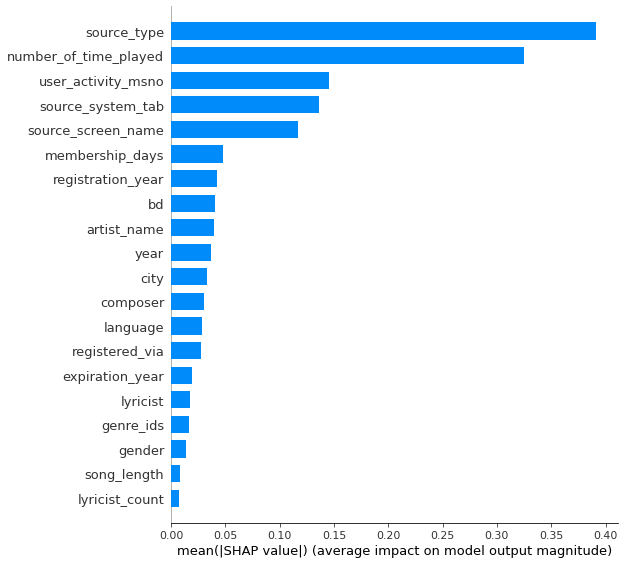

In [148]:
shap.summary_plot(shap_values, X_train, plot_type="bar")


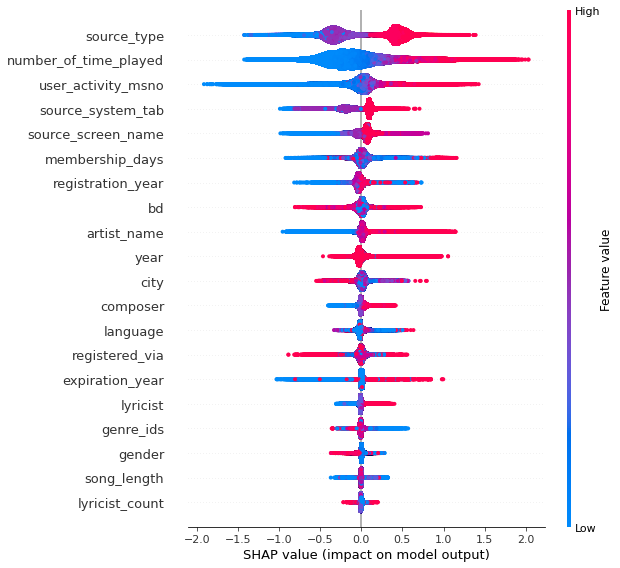

In [152]:
shap.summary_plot(shap_values, X_train)


Hyperparameter optimization

In [181]:
dtrain_optimize = xgb.DMatrix(X_train[:200000], y_train[:200000])

In [182]:
AUCbest = 0
ITERbest = 0

In [183]:
def optimize_xgboost(
          max_depth,
          gamma,
          min_child_weight,
          max_delta_step,
          subsample,
          colsample_bytree,
          lr
         ):

    global AUCbest
    global ITERbest

    params = {
              'max_depth' : int(max_depth),
              'gamma' : gamma,
              'eta' : 0.1,
              'objective' : 'binary:logistic',
              'nthread' : 46,
              'silent' : True,
              'eval_metric': 'auc',
              'subsample' : max(min(subsample, 1), 0),
              'colsample_bytree' : max(min(colsample_bytree, 1), 0),
              'min_child_weight' : min_child_weight,
              'max_delta_step' : int(max_delta_step),
              'seed' : 228,
              'learning_rate': lr,
              'max_bin': 256,
              }

    folds = 5
    cv_score = 0
    xgbc = xgb.cv(
                    params,
                    dtrain_optimize,
                    num_boost_round = 400,
                    stratified = True,
                    nfold = folds,
                    early_stopping_rounds = 100,
                    metrics = 'auc',
                    show_stdv = True
               )
    val_score = xgbc['test-auc-mean'].iloc[-1]
    train_score = xgbc['train-auc-mean'].iloc[-1]
    if ( val_score > AUCbest ):
        AUCbest = val_score
        ITERbest = len(xgbc)

    return (val_score*2) - 1

In [184]:
from bayes_opt import BayesianOptimization

In [185]:
xgb_bo = BayesianOptimization(optimize_xgboost, {
                                     'max_depth': (5, 15),
                                     'gamma': (0.001, 10.0),
                                     'min_child_weight': (0, 20),
                                     'max_delta_step': (0, 10),
                                     'subsample': (0.4, 1.0),
                                     'colsample_bytree' :(0.4, 1.0),
                                     'lr': (0.05, 0.5)
                                    })

In [186]:
xgb_bo.maximize(init_points=3, n_iter=10, acq='ei', xi=0.0)

|   iter    |  target   | colsam... |   gamma   |    lr     | max_de... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------
[19:14:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:14:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

In [192]:
xgb_bo.max

{'target': 0.4247132,
 'params': {'colsample_bytree': 0.4,
  'gamma': 10.0,
  'lr': 0.05,
  'max_delta_step': 6.812252674617146,
  'max_depth': 14.028543696379069,
  'min_child_weight': 1.6866629240286883,
  'subsample': 1.0}}

In [199]:
xgb_train = xgb.DMatrix(X_train, y_train)

In [200]:
X_test_processed = ppl.transform(X_test)

In [201]:
X_test = pd.DataFrame(columns=list(num_features)+list(cat_features), data=X_test_processed)

In [202]:
xgb_test = xgb.DMatrix(X_test, y_test)

In [203]:
params = {
        'objective': 'binary:logistic',
        'colsample_bytree': 0.4,
        'gamma': 10.0,
        'lr': 0.05,
        'max_delta_step': int(6.812252674617146),
        'max_depth': int(14.028543696379069),
        'min_child_weight': 1.6866629240286883,
        'max_bin': 256,
        'subsample': 1
    }

In [204]:
bst = xgb.train(params, xgb_train, 50)

[19:54:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { lr } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:54:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [205]:
from sklearn.metrics import roc_auc_score

In [206]:
roc_auc_score(y_test, bst.predict(xgb_test))

0.7667362615845167

Вроде стало чуть получше

## ЧАСТЬ 2

In [98]:
import gensim

Song ID немного сломана и иногда одинаковые треки обозначает по разному (видимо дело как и в ВК, один и тот же трек может быть залит по несколько раз). Чтобы избежать этого, сделаем колонку artistname_songname, т.к. у разных артистов могут быть одинаковые треки. Будем составлять векторы песен не только по принадлежности к одному юзеру, но и к контексту юзера (какую вкладку он слушает, дискавер там или свои лайкнутые песни. В зависимости от контекста это могут быть совершенно разные стили и тд)

In [99]:
from collections import defaultdict

Так как здесь нам уже эта колонка становится важнее, не будем закидывать ее просто самыми частыми значениями, что хорошо работало раньше, а выделим в отдельную категорию (т.к. иначе у нас в "предложения" для word2vec могут попасть совсем левые композиции)

In [ ]:
train['source_system_tab'] = train['source_system_tab'].cat.add_categories('Unknown')
train['source_system_tab'].fillna('Unknown', inplace=True) 

In [103]:
train['msno'].isnull().values.any()

False

In [104]:
song_sentences = defaultdict(list)
for i, row in tqdm(train[train['target'] == 1].iterrows(), total=train[train['target'] == 1].shape[0]):
    song_sentences[f"{row['msno']}_{row['source_system_tab']}"].append(f"{row['artist_name']}_{row['name']}")

In [105]:
import multiprocessing

In [106]:
from gensim.models import Word2Vec


In [109]:
w2v = Word2Vec(min_count=2,
                     window=10,
                     size=30,
                     negative=18,
                     sg=1,
                     workers=multiprocessing.cpu_count()-1)

In [110]:
sent = list(song_sentences.values())

In [111]:
len(sent)

65592

In [112]:
w2v.build_vocab(sent)

In [113]:
w2v.train(sent, total_examples=w2v.corpus_count, epochs=18)

(65182712, 66863808)

In [208]:
w2v.init_sims(replace=True)


In [115]:
w2v.wv.most_similar(positive="The Chainsmokers_Don't Let Me Down")

[('Calvin Harris_This Is What You Came For', 0.9866588115692139),
 ('The Chainsmokers_All We Know', 0.986282467842102),
 ('DJ Snake_Let Me Love You', 0.9839890003204346),
 ('The Chainsmokers_Closer', 0.9805313348770142),
 ('Alan Walker_Sing Me to Sleep', 0.9801279902458191),
 ("CHARLIE PUTH_We Don't Talk Anymore", 0.965783953666687),
 ('Alan Walker_Faded', 0.9571183919906616),
 ('Justin Bieber_Love Yourself', 0.9501611590385437),
 ('Alan Walker_Alone', 0.9396958947181702),
 ('Mike Posner_I Took A Pill In Ibiza', 0.9269013404846191)]

In [118]:
w2v.wv.most_similar(positive="Eminem_Rap God")

[('Juicy J| Wiz Khalifa| Ty Dolla $ign_Shell Shocked (feat. Kill The Noise & Madsonik)',
  0.8954509496688843),
 ('Eminem_Without Me', 0.8908243179321289),
 ('Eminem_Stan', 0.8862687349319458),
 ('Kanye West_Stronger(更強)', 0.8789663314819336),
 ('Jay-Z_Empire State Of Mind', 0.8781973123550415),
 ('Swisher Swift_All the Way up (feat. Mirk)', 0.8733759522438049),
 ('Dr. Dre_The Next Episode', 0.8712133765220642),
 ('Eminem_Berzerk', 0.8674595355987549),
 ('Eminem & Dr. Dre & 50 Cent_Crack A Bottle', 0.8663102388381958),
 ("Eminem_I'm Shady", 0.8615760803222656)]

In [124]:
w2v.wv.most_similar(positive="Headhunterz_Once Again")

[('Headhunterz_The Power of the Mind (Qlimax Anthem 2007)',
  0.9046775102615356),
 ('W&W| Hardwell| Lil Jon_Live The Night', 0.8806696534156799),
 ('W&W_How Many', 0.8562552332878113),
 ("EDM Stars_I'm All Yours", 0.8505021333694458),
 ('BIRDY_You Used To Shine', 0.8478317260742188),
 ("Lucas Nord_Don't Need Your Love", 0.8460643291473389),
 ('Hardwell_United We Are', 0.843499481678009),
 ('Penthox_Give It Away', 0.8421807885169983),
 ('Headhunterz_Scrap Attack (Defqon.1 Anthem 2009)', 0.841334342956543),
 ('Hardwell_Young Again', 0.8380181193351746)]

In [128]:
w2v.wv.most_similar(positive="Brennan Heart_Outta My Way")

[('Atmozfears_Hate', 0.9708410501480103),
 ('Atmozfears_Whiplashed', 0.9665583968162537),
 ('Frontliner and Radical Redemption_Frontliner & Radical Redemption',
  0.9448591470718384),
 ('E-Force_Blood Written (Qapital Anthem 2015)', 0.9228447079658508),
 ("Dillon Francis_I Can't Take It (Party Favor Remix)", 0.9004954695701599),
 ('Drauf & Dran feat. Kalletti Klub_Voulez vous', 0.8858458399772644),
 ('Getter| Ghastly_666!', 0.8755720257759094),
 ('Drauf & Dran feat. Kalletti Klub_Das gewisse Etwas', 0.8750038146972656),
 ('Doctor P_Rekt Together (Every Single Night)', 0.8744133710861206),
 ('NAVVI_Close', 0.8734849095344543)]

Для менее популярных стилей и артистов работает чуть хуже, но все равно достаточно норм, однако это можно объяснить малым их числом в датасете и накладывающимся еще менее популярным артистом.

In [133]:
w2v.save('w2v.model')

In [207]:
w2v = Word2Vec.load('w2v.model')

In [209]:
userembed = {}

In [210]:
word_vectors = w2v.wv

In [211]:
len(word_vectors.vocab)

103763

In [212]:
def get_user_embedding(row):
    user_name = f"{row['msno']}_{row['source_system_tab']}"
    if user_name in userembed:
        return userembed[user_name]
    embedding = np.zeros(30,)
    for song in song_sentences[user_name]:
        if song in word_vectors.vocab:
            embedding += w2v.wv.word_vec(song)
    userembed[user_name] = embedding
    return embedding

In [213]:
user_embeddings = np.vstack(train.progress_apply(get_user_embedding, axis=1))

In [214]:
def get_item_embedding(row):
    song_name = f"{row['artist_name']}_{row['name']}"
    if song_name in word_vectors.vocab:
        return w2v.wv.word_vec(song_name)
    else:
        return np.zeros(30,)

In [215]:
item_embeddings = np.vstack(train.progress_apply(get_item_embedding, axis=1))

In [216]:
scores = (item_embeddings * user_embeddings).mean(axis=1)

In [217]:
roc_auc_score(train['target'], scores)

0.6871609532181814

Да, скор чуть пониже, но мы по сути заюзали всего пару фичей, попробуем постекать и тд 

In [218]:
X['emb'] = scores

In [219]:
cat_features = ['source_system_tab', 'source_screen_name', 'source_type', 'artist_name',
                'composer', 'lyricist', 'gender', 'genre_ids', 'language', 'city', 'registered_via']

num_features = set(X.columns) - set(cat_features)

In [220]:
num_features

{'artist_count',
 'bd',
 'composer_count',
 'emb',
 'expiration_year',
 'genre_ids_count',
 'lyricist_count',
 'membership_days',
 'number_of_time_played',
 'registration_year',
 'song_length',
 'user_activity_msno',
 'year'}

In [65]:
import category_encoders as ce

In [66]:
numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='most_frequent'))])
    ('encoder', ce.cat_boost.CatBoostEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, list(num_features)),
        ('cat', categorical_transformer, list(cat_features))])

ppl = Pipeline(steps=[('preprocessor', preprocessor)])

Импьютеры почему-то у меня ложили ноутбук намертво, пришлось руками

In [67]:
X.loc[:,num_features] = X[num_features].fillna(X[num_features].median().iloc[0])

In [68]:
X.loc[:,cat_features] = X[cat_features].fillna(X[cat_features].mode().iloc[0])

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [70]:
X_train_processed = ppl.fit_transform(X_train, y_train)

In [71]:
X_train = pd.DataFrame(columns=list(num_features)+list(cat_features), data=X_train_processed)

In [72]:
X_train.head()

,expiration_year,year,composer_count,lyricist_count,emb,artist_count,genre_ids_count,number_of_time_played,bd,registration_year,...,source_screen_name,source_type,artist_name,composer,lyricist,gender,genre_ids,language,city,registered_via
0,-0.180081,0.199650,-0.233701,0.126405,1.326116,-0.083708,-0.126818,2.768462,1.041071,0.086175,...,0.503517,0.503517,0.503517,0.503517,0.503517,0.503517,0.503517,3.0,4.0,9.0
1,-0.180081,-0.103429,0.387924,0.126405,-0.080990,-0.083708,-0.126818,0.240361,0.902026,0.417380,...,0.503517,0.503517,0.503517,0.503517,0.503517,0.503517,0.751759,3.0,15.0,9.0
2,-0.180081,0.048110,-0.233701,-0.706334,-0.868208,-0.083708,-0.126818,-0.635064,0.392194,-1.569847,...,0.751759,0.751759,0.503517,0.503517,0.503517,0.751759,0.503517,31.0,4.0,9.0
3,-2.693659,-1.921901,-0.855325,-0.706334,-0.850968,-0.083708,-0.126818,-0.634676,0.670284,-1.238643,...,0.251759,0.503517,0.503517,0.503517,0.251759,0.251759,0.501172,52.0,13.0,9.0
4,2.333496,0.502728,-0.233701,0.126405,-0.847520,-0.083708,-0.126818,-0.578798,0.577587,-0.245029,...,0.503517,0.503517,0.503517,0.503517,0.503517,0.167839,0.503517,3.0,4.0,9.0


In [73]:
import xgboost as xgb

In [74]:
xgb_train = xgb.DMatrix(X_train, y_train)

In [75]:
X_test_processed = ppl.transform(X_test)

In [76]:
X_test = pd.DataFrame(columns=list(num_features)+list(cat_features), data=X_test_processed)

In [77]:
xgb_test = xgb.DMatrix(X_test, y_test)

In [78]:
params = {
        'objective': 'binary:logistic',
        'learning_rate': 0.3 ,
        'max_bin': 256,
        'max_depth': 10,
    }

In [79]:
bst = xgb.train(params, xgb_train, 30)

[18:25:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [80]:
from sklearn.metrics import roc_auc_score

In [81]:
roc_auc_score(y_test, bst.predict(xgb_test))

0.7851527646426419

С вашего позволения делать кроссвал снова не буду (слишком уж большой датасет, не думаю, что что-то сильно поменялось), но налицо видно, что скор значительно увеличился. Посмотрим на shap

In [83]:
import shap
shap.initjs()


In [84]:
explainer = shap.TreeExplainer(bst)

In [85]:
shap_values = explainer.shap_values(X_train[:100])

На всем датасете шап строится слишком долго, построим на части. Даже так видно, что импакт новой фичи максимальный

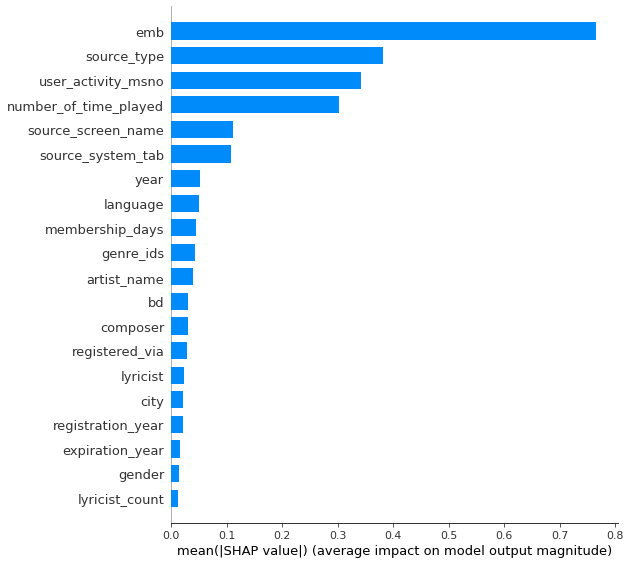

In [87]:
shap.summary_plot(shap_values, X_train[:100], plot_type="bar")

In [221]:
artist2vec = {}
artist_song_df = train[['artist_name', 'name']]

In [222]:
artist_song_df.shape

(7377418, 2)

In [223]:
artist_song_df = artist_song_df.drop_duplicates()

In [224]:
artist_song_dict = artist_song_df.groupby("artist_name")['name'].apply(list).to_dict()

In [248]:
artist2embedding = defaultdict(list)

In [249]:
for artist in tqdm(artist_song_dict):
    artist_songs = []
    for song in artist_song_dict[artist]:
        song_name = f"{artist}_{song}"
        if song_name in word_vectors.vocab:
            artist_songs.append(w2v.wv.word_vec(song_name))
    if len(artist_songs) > 0:
        artist2embedding[artist] = np.sum(artist_songs, axis=0)

In [250]:
from sklearn.metrics.pairwise import cosine_similarity

In [251]:
a = artist2embedding['Headhunterz'].reshape(-1, 1)
b = artist2embedding['Brennan Heart'].reshape(-1, 1)

In [252]:
a.shape

(30, 1)

In [253]:
b.shape

(30, 1)

In [254]:
np.dot(a.T, b) / (np.linalg.norm(a) * np.linalg.norm(b))

array([[0.6947718]], dtype=float32)

In [255]:
a = artist2embedding['Eminem'].reshape(-1, 1)
b = artist2embedding['Brennan Heart'].reshape(-1, 1)

In [256]:
np.dot(a.T, b) / (np.linalg.norm(a) * np.linalg.norm(b))

array([[0.54494464]], dtype=float32)

Давайте заюзаем

In [260]:
X['artist_embedding'] = X['artist_name'].progress_apply(lambda x: np.mean(artist2embedding[x]))

In [261]:
cat_features = ['source_system_tab', 'source_screen_name', 'source_type', 'artist_name',
                'composer', 'lyricist', 'gender', 'genre_ids', 'language', 'city', 'registered_via']

num_features = set(X.columns) - set(cat_features)

In [262]:
num_features

{'artist_count',
 'artist_embedding',
 'bd',
 'composer_count',
 'emb',
 'expiration_year',
 'genre_ids_count',
 'lyricist_count',
 'membership_days',
 'number_of_time_played',
 'registration_year',
 'song_length',
 'user_activity_msno',
 'year'}

In [263]:
import category_encoders as ce

In [264]:
numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='most_frequent'))])
    ('encoder', ce.cat_boost.CatBoostEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, list(num_features)),
        ('cat', categorical_transformer, list(cat_features))])

ppl = Pipeline(steps=[('preprocessor', preprocessor)])

Импьютеры почему-то у меня ложили ноутбук намертво, пришлось руками

In [265]:
X.loc[:,num_features] = X[num_features].fillna(X[num_features].median().iloc[0])

In [266]:
X.loc[:,cat_features] = X[cat_features].fillna(X[cat_features].mode().iloc[0])

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [268]:
X_train_processed = ppl.fit_transform(X_train, y_train)

In [269]:
X_train = pd.DataFrame(columns=list(num_features)+list(cat_features), data=X_train_processed)

In [270]:
X_train.head()

,bd,artist_embedding,user_activity_msno,emb,genre_ids_count,registration_year,expiration_year,year,lyricist_count,composer_count,...,source_screen_name,source_type,artist_name,composer,lyricist,gender,genre_ids,language,city,registered_via
0,0.947882,0.207476,-0.575108,-0.213038,-0.126884,0.086148,-0.179354,0.294833,0.126790,-0.233550,...,0.503517,0.503517,0.503517,0.503517,0.503517,0.503517,0.503517,3.0,22.0,7.0
1,-0.813005,-0.096958,-0.289130,0.326124,-0.126884,1.079794,-0.179354,0.291094,-0.706819,-0.855282,...,0.251759,0.251759,0.503517,0.503517,0.503517,0.251759,0.251759,52.0,1.0,13.0
2,0.577169,0.148445,0.491759,-0.683867,-0.126884,0.417363,2.328153,0.296703,-0.706819,1.631643,...,0.501172,0.501172,0.503517,0.503517,0.751759,0.501172,0.501172,52.0,14.0,3.0
3,0.206456,0.217292,-0.798405,-0.405156,-0.126884,0.748578,2.328153,0.296703,0.126790,-0.233550,...,0.375879,0.503517,0.503517,0.503517,0.503517,0.503517,0.503517,3.0,1.0,3.0
4,-0.813005,0.162793,-0.646929,-0.692665,-0.126884,-0.576283,-0.179354,0.300442,-0.706819,-0.233550,...,0.300703,0.251759,0.503517,0.503517,0.501172,0.375879,0.503517,17.0,1.0,7.0


In [271]:
xgb_train = xgb.DMatrix(X_train, y_train)

In [272]:
X_test_processed = ppl.transform(X_test)

In [273]:
X_test = pd.DataFrame(columns=list(num_features)+list(cat_features), data=X_test_processed)

In [274]:
xgb_test = xgb.DMatrix(X_test, y_test)

In [290]:
params = {
        'objective': 'binary:logistic',
        'colsample_bytree': 0.4,
        'gamma': 10.0,
        'max_delta_step': int(6.812252674617146),
        'max_depth': int(14.028543696379069),
        'min_child_weight': 1.6866629240286883,
        'max_bin': 256,
        'subsample': 1
    }

In [291]:
bst_all = xgb.train(params, xgb_train, 50)

[20:47:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [292]:
from sklearn.metrics import roc_auc_score

In [293]:
roc_auc_score(y_test, bst_all.predict(xgb_test))

0.8020297370843922

In [350]:
xgb_cv = cv(dtrain=xgb_train, params=params, nfold=5,
                    num_boost_round=40, early_stopping_rounds=20, metrics="auc", as_pandas=True, seed=123)

[21:35:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[21:35:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[21:35:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[21:35:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for fa

In [354]:
xgb_cv.sort_values(by='test-auc-mean', ascending=False)

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
39,0.815659,0.001182,0.798341,0.000982
38,0.814908,0.001213,0.797875,0.000968
37,0.814073,0.001063,0.797328,0.000862
36,0.813801,0.001053,0.797207,0.000855
35,0.813299,0.000966,0.796941,0.000791
34,0.812303,0.001296,0.796232,0.001060
33,0.811194,0.001184,0.795444,0.001025
32,0.810552,0.001489,0.795070,0.001315
31,0.810012,0.001173,0.794745,0.001074
30,0.809314,0.001386,0.794304,0.001263


Вроде стало еще чуть получше

В итоге имеем, что эмбеддинги могут дать прирост, и даже отдельно работают довольно неплохо.

Попробуем обучить бустинг чисто на матрицах юзер и айтем ебмеддингов

In [299]:
naked_xgb_train = xgb.DMatrix(item_embeddings[:-10000] * user_embeddings[:-10000], train.target[:-10000])

In [301]:
naked_xgb_test = xgb.DMatrix(item_embeddings[-10000:] * user_embeddings[-10000:], train.target[-10000:])

In [302]:
bst_naked = xgb.train(params, naked_xgb_train, 50)

[21:03:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [303]:
roc_auc_score(naked_xgb_test.get_label(), bst_naked.predict(naked_xgb_test))

0.7543473468611175

In [314]:
X_final_test, y_final_test = ppl.transform(X.iloc[-10000:]), y[-10000:]

In [315]:
X_final_test = pd.DataFrame(columns=list(num_features)+list(cat_features), data=X_final_test)

In [316]:
bst_all_final_test = xgb.DMatrix(X_final_test, y_final_test)
bst_final_test = xgb.DMatrix(X_final_test[bst.feature_names], y_final_test)

In [317]:
models = [(naked_xgb_test, bst_naked), (bst_final_test, bst), (bst_all_final_test, bst_all)]

In [320]:
from scipy.stats import mode

In [326]:
a = np.array([[1,2,3,1,2,1,1,1,3,2,2,1], [2,1,2,3,1,2,1,1,1,3,2,2], [2,1,2,3,1,2,1,1,1,3,2,2]]).T
counts = mode(a, 1)

In [327]:
a

array([[1, 2, 2],
       [2, 1, 1],
       [3, 2, 2],
       [1, 3, 3],
       [2, 1, 1],
       [1, 2, 2],
       [1, 1, 1],
       [1, 1, 1],
       [3, 1, 1],
       [2, 3, 3],
       [2, 2, 2],
       [1, 2, 2]])

In [330]:
results = np.zeros((X_final_test.shape[0], 3))

In [332]:
for idx, (dataset, model) in enumerate(models):
    results[:, idx] = model.predict(dataset)

In [348]:
roc_auc_score(bst_final_test.get_label(), results.mean(axis=1))

0.7892187306934428

In [349]:
roc_auc_score(bst_final_test.get_label(), results[:, 2])

0.7831595044915025

К сожалению писать cv уже по такому не успеваю, но подозреваю, что там также результаты по среднему среди всех классификаторов показывали бы лучший возможный результат, совсем немного опережающий модель bst_all. (Значения рок аук в конце получились чуть меньше из-за неудачно отложенной выборки, по cv выше это можно понять)